# Inżynieria Uczenia Maszynowego

Studenci:
```
Bartłomiej Krawczyk
Mateusz Brzozowski
```

## Temat

> “Jakiś czas temu wprowadziliśmy konta premium, które uwalniają użytkowników od słuchania reklam. Nie są one jednak jeszcze zbyt popularne – czy możemy się dowiedzieć, które osoby są bardziej skłonne do zakupu takiego konta?”

In [1]:
import itertools
import numpy as np
import pandas as pd
import pickle
import requests

from math import sqrt
from matplotlib import pyplot as plt
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from typing import Any, Dict, Optional
from xgboost import XGBClassifier


from microservice import IUMModel
from utility import (
    plot_matrix,
    construct_dummy,
    construct_logistic_reggression,
    plot_confusion_matrix,
    plot_confusion_matrix_ab_experiment,
    plot_feature_importances,
    get_params,
    compare_models,
    Model,
    FEATURES,
    TARGETS,
    TARGET_AND_FEATURES,
    DUMMY,
    LOGISTIC_REG,
    XGB,
    XGB_BEST_ESTIMATOR,
    MODEL_TYPES,
    SERVICE_PREDICTION_MODEL_INIT,
    AB_RESULT
)

## Cechy i funkcje celu

Do trenowania naszych modeli przygotowaliśmy następujące cechy wygenerowane na podstawie dostarczonych danych:
- `number_of_advertisements`, ilość odtworzonych reklam w danym miesiącu
- `number_of_tracks`, ilość przesłuchanych utworów w danym miesiącu
- `number_of_skips`, ilość pominiętych utworów w danym miesiącu
- `number_of_likes`, liczba danych lików w danym miesiącu
- `number_of_liked_tracks_listened`, liczba przesłuchanych utworów w danym miesiącu, które w momencie odtworzenia były polubione
- `number_of_tracks_in_favourite_genre`, liczba przesłuchanych utworów z ulubionego gatunku w danym miesiącu
- `total_number_of_favourite_genres_listened`, liczba przesłuchanych gatunków w danym miesiącu należących do ulubionych użytkownika
- `average_popularity_in_favourite_genres`, średnia popularność utworów wśród ulubionych gatunków w danym miesiącu
- `total_tracks_duration_ms`, całkowity czas przesłuchanych utworów w danym miesiącu
- `number_of_different_artists`, ilość przesłuchanych artystów w danym miesiącu
- `average_release_date`, średnia data przesłuchanych piosenek w danym miesiącu
- `average_duration_ms`, średni czas trwania utworów przesłuchanych w danym miesiącu
- `explicit_tracks_ratio`, ułamek "wulgarnych" utworów przesłuchanych w danym miesiącu
- `average_popularity`, średnia popularność przesłuchanych utworów w danym miesiącu
- `average_acousticness`, średnia akustyka przesłuchanych utworów w danym miesiącu
- `average_danceability`, średnia taneczność przesłuchanych utworów w danym miesiącu
- `average_energy`, średnia moc przesłuchanych utworów w danym miesiącu
- `average_instrumentalness`, średnia ilość utworów z wokalem przesłuchanych w danym miesiącu
- `average_liveness`, średnie brzmienie utworów na żywo przesłuchanych w danym miesiącu
- `average_loudness`, średnia głośność przesłuchanych utworów w danym miesiącu
- `average_speechiness`, średnia ilość wokalu w utworach przesłuchanych w danym miesiącu
- `average_tempo`, średnia prędkość przesłuchanych utworów w danym miesiącu
- `average_valence`, średnia emocjonalność przesłuchanych utworów w danym miesiącu
- `average_track_name_length`, średnia długość nazwy utworów przesłuchanych w danym miesiącu
- `average_daily_cost`, średni koszt utrzymania przesłuchanych piosenek w danym miesiącu

Posiadamy również dwie funkcje celu:
- `premium_user_numerical`, która określa czy użytkownik kiedykolwiek kupi premium
- `will_buy_premium_next_month_numerical` przedstawiająca to czy użytkownik zakupi premium w przeciągu następnych 30 dni


In [2]:
FEATURE_VERSION = 'v1'
FEATURE_PATH = f'features/{FEATURE_VERSION}/feature.csv'

In [3]:
data_frame = pd.read_csv(FEATURE_PATH)

### Przykładowe wartości cech oraz funkcji celu

In [4]:
data_frame.head()

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,212,2020,2,1,0,0,10,30,16,8,...,0.542767,0.600467,0.094653,0.179113,-10.158167,0.049070,121.964467,0.588167,22.233333,0.012134
1,212,2020,7,1,0,0,5,16,8,2,...,0.499000,0.675250,0.150966,0.226225,-8.795062,0.061812,123.069063,0.452131,22.687500,0.014780
2,212,2020,1,1,0,0,14,39,21,12,...,0.487000,0.691667,0.119363,0.235690,-9.491795,0.064918,123.745769,0.564369,19.461538,0.012399
3,212,2020,3,1,0,0,3,20,9,6,...,0.516700,0.637150,0.069641,0.189545,-8.409150,0.053715,121.415600,0.586000,21.250000,0.012706
4,212,2020,8,1,0,0,13,40,22,12,...,0.513525,0.642350,0.112645,0.285203,-9.562400,0.055282,120.922325,0.510517,24.000000,0.013076


### Macierz korelacji cech z wartościami przewidywanymi
Sprawdzamy korelację cech, które nie są zbytnio skorelowane między sobą, a za to są skorelowane z targetem.

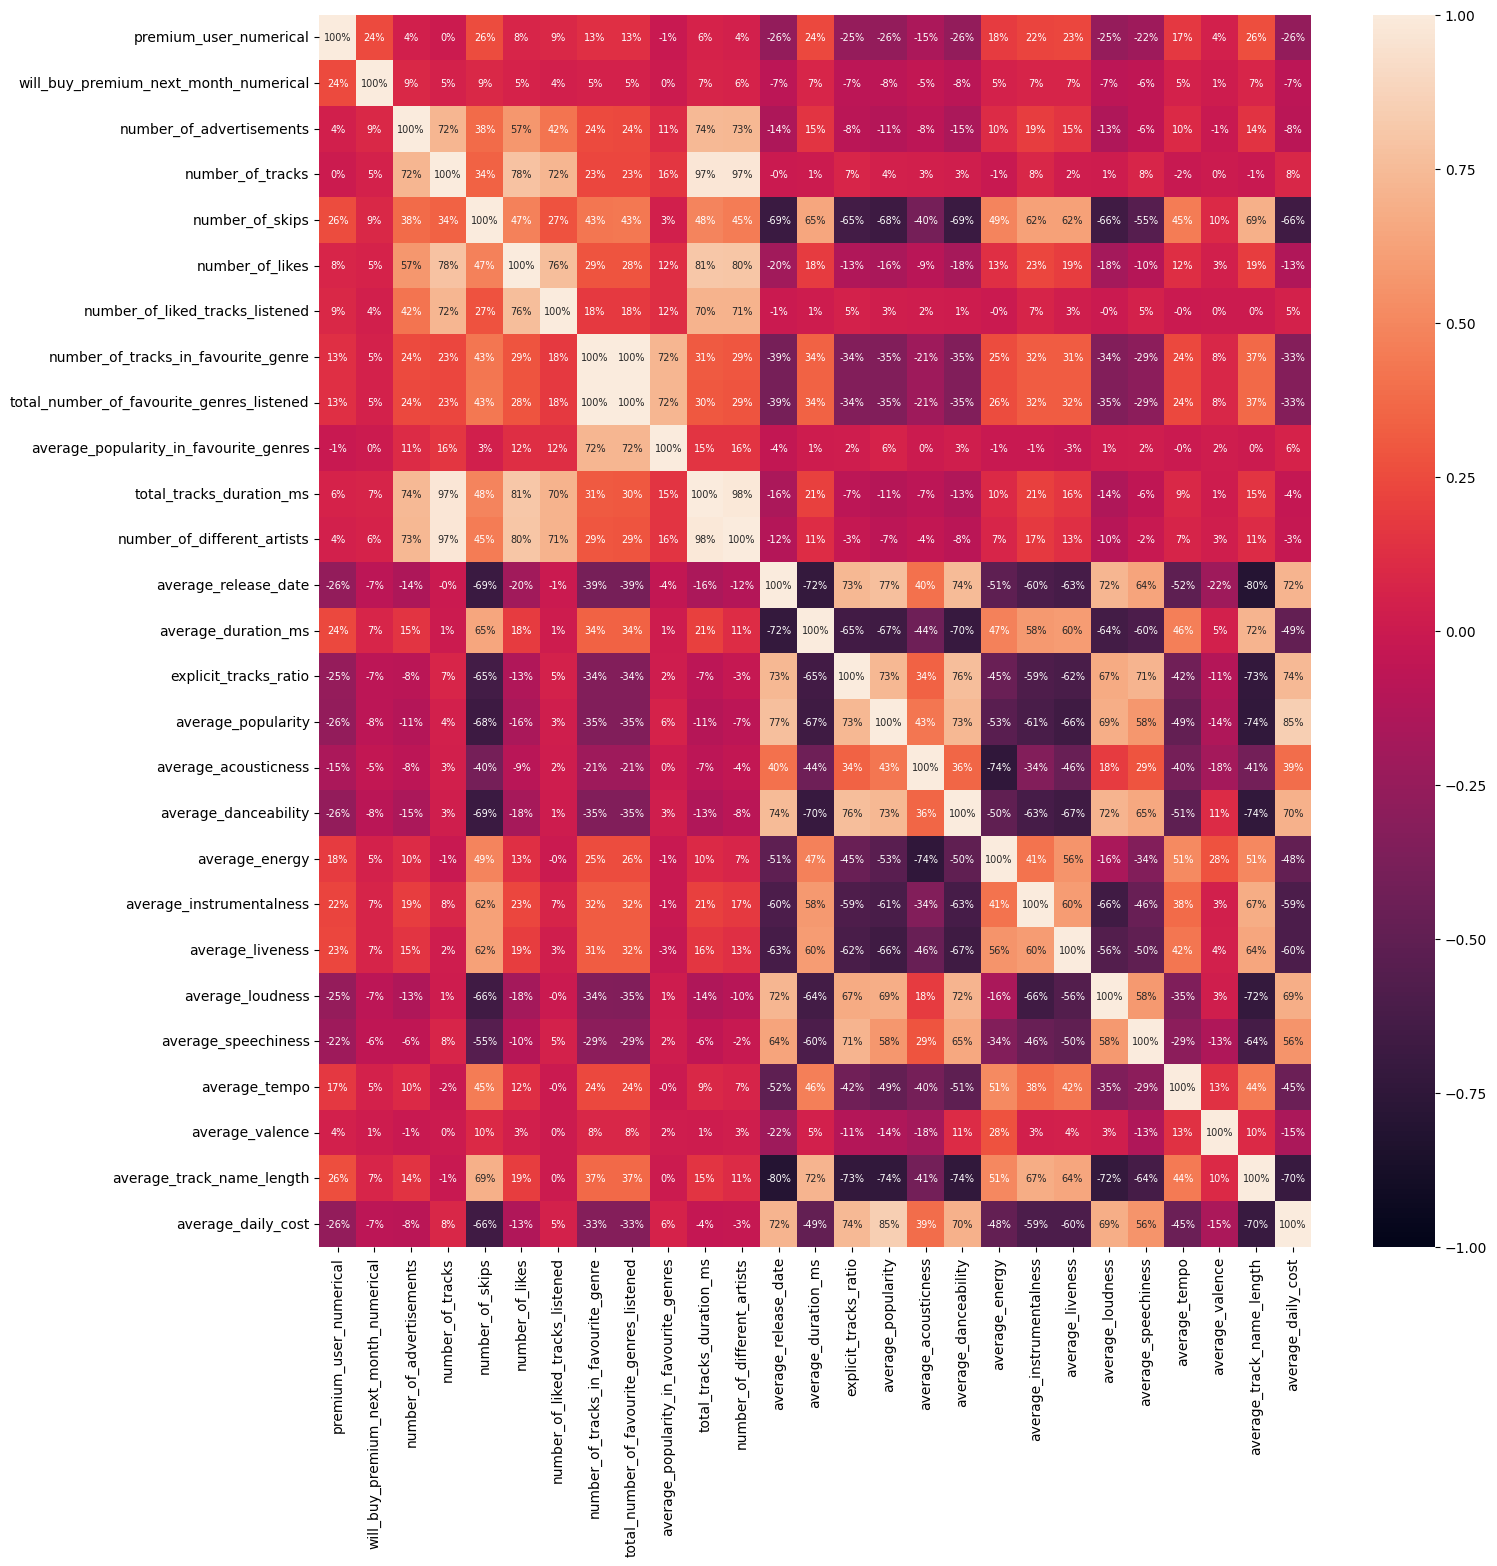

In [5]:
correlation_matrix = data_frame.loc[:, TARGET_AND_FEATURES] \
    .corr(method='spearman')

plot_matrix(correlation_matrix)

In [4]:
RANDOM_SEED: int = 7446640
np.random.seed(RANDOM_SEED)

Definiujemy pipeline do uzupełnienia danych pustych oraz przeskalowania danych

In [5]:
pipeline = Pipeline([
    ("simple_imputer", SimpleImputer()),
    ("standard_scaler", StandardScaler())
])

Dzielimy dane na dane trenujące oraz testowe do późniejszych eksperymentów A/B

In [6]:
TRAINING_UP_TO = 2023
TRAIN_DATA: pd.DataFrame = data_frame.loc[data_frame.year < TRAINING_UP_TO, :]
TEST_DATA: pd.DataFrame = data_frame.loc[data_frame.year >= TRAINING_UP_TO, :]
TEST_SIZE = 0.33

Pipeline uczony jest na podstawie samych danych testowych


In [8]:
X_train_temp, X_test_temp, Y_train, Y_test = train_test_split(
    TRAIN_DATA[FEATURES],
    TRAIN_DATA[TARGETS],
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)
X_train_temp: pd.DataFrame
X_test_temp: pd.DataFrame
Y_train: pd.DataFrame
Y_test: pd.DataFrame

train_data = pipeline.fit_transform(X_train_temp)
test_data = pipeline.transform(X_test_temp)
X_train = pd.DataFrame(train_data, columns=FEATURES)
X_test = pd.DataFrame(test_data, columns=FEATURES)

### Cechy przetworzone przez pipeline

In [10]:
X_train.head()

,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,number_of_liked_tracks_listened,number_of_tracks_in_favourite_genre,total_number_of_favourite_genres_listened,average_popularity_in_favourite_genres,total_tracks_duration_ms,number_of_different_artists,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,1.631673,1.567461,2.537417,1.696418,0.851842,-0.078032,-0.119100,0.175855,1.468009,1.652443,...,-1.017931,0.736664,0.521800,0.889386,-0.485768,-0.689657,-0.246950,0.829451,0.780251,-1.317876
1,-1.108052,-1.659811,-0.539252,-1.370932,-1.093532,-0.454677,-0.447345,0.002126,-1.580864,-1.699180,...,-1.159126,1.676498,-0.159661,0.683955,-0.892305,-1.200897,0.437162,1.650610,1.119204,-1.164683
2,2.627937,1.567461,-0.881104,0.581018,1.435454,-0.643000,-0.611468,-1.011289,1.231813,1.293340,...,0.710167,-0.194875,-0.822834,-0.217045,0.389305,-0.398918,-0.609566,-0.235951,-0.561631,1.217974
3,-0.111788,-0.877442,-0.881104,-0.534382,-1.093532,-0.643000,-0.611468,-1.011289,-1.004172,-0.980975,...,0.433267,0.022840,-0.414532,-1.182883,0.463848,1.543094,0.649368,-1.897642,-0.618064,2.375377
4,0.884475,0.882889,-0.539252,-0.255532,2.213603,0.486936,0.373267,1.391953,0.567597,0.335734,...,0.854788,-0.262065,-0.942332,-0.972696,0.746466,0.340184,-0.935799,0.385874,-0.901333,0.921839


In [11]:
Y_train.head()

,premium_user_numerical,will_buy_premium_next_month_numerical
62076,1,0
19848,1,0
23994,1,0
130351,0,0
138271,0,0


# Modele

Do porównywania wybraliśmy cztery modele:

- `Dummy` - naiwny model, który zawsze przewiduje najczęściej występującą klasę
- `Logistic Regression` - model regresji logistycznej z domyślnymi parametrami
- `XGB Classifier` - model XGBoost z domyślnymi parametrami
- `XGB Classifier with Randomized Search` - model XGBoost z Randomized Search. Randomized Search to metoda optymalizacji hiperparametrów, która polega na losowym testowaniu zdefiniowane wartości hiperparametrów i ustaleniu ich najlepszej kombinacji. W ten sposób można znaleźć dobre parametry modelu bez konieczności przeszukiwania całej przestrzeni hiperparametrów. Dodatkowo, aby przeciwdziałać niezbalansowanym danym ustawiliśmy parametr `scale_pos_weight` według zaleceń na stosunek liczby negatywnych rekordów (0) do liczby pozytywnych (1).

In [12]:
def construct_xgb_classifier(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    params: Optional[Dict[str, Any]] = None
) -> XGBClassifier:
    return XGBClassifier(
        random_state=RANDOM_SEED
    ).fit(X_train, y_train)


def construct_xgb_classifier_with_randomized_search(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    params: Optional[Dict[str, Any]] = None
) -> XGBClassifier:
    if params:
        return XGBClassifier(**params).fit(X_train, y_train)
    scale = y_train.value_counts()
    model = XGBClassifier(scale_pos_weight=scale[0] / scale[1])

    randomized_search_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions={
            'max_depth': range(3, 25),
            'eta': uniform(0, 0.3),
            'gamma': uniform(0, 1),
            'n_estimators': range(10, 100),
        },
        n_iter=300,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=3,
        random_state=RANDOM_SEED
    )
    estimator = randomized_search_cv.fit(X_train, y_train)
    best_estimator = estimator.best_estimator_
    print('Best parameters:', best_estimator.get_params())  # type: ignore
    return best_estimator  # type: ignore


MODEL_CONSTRUCTORS = {
    DUMMY: construct_dummy,
    LOGISTIC_REG: construct_logistic_reggression,
    XGB: construct_xgb_classifier,
    XGB_BEST_ESTIMATOR: construct_xgb_classifier_with_randomized_search
}

MODELS: Dict[str, Dict[str, Model]] = {
    type: {
        target: MODEL_CONSTRUCTORS[type](X_train, Y_train[target])
        for target in TARGETS
    }
    for type in MODEL_TYPES
}

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters: {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.01755037568473161, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 66, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 2.671083992754314, 'subsample': None, 'tree_method': None, 'validate_parameters':

# Ocena modeli

Posiadamy niezbalansowane dane, dlatego też do oceny modeli wykorzystaliśmy metrykę `ROC-AUC`, która jest miarą jakości klasyfikatora binarnego. 

`ROC-AUC` mierzy zdolność modelu do rozróżnienia między dwiema klasami poprzez obliczenie powierzchni pod krzywą ROC. Krzywa ROC przedstawia zależność między wskaźnikiem True Positive Rate = TP / ( TP + FN) (czułość) a False Positive Rate = FP / (FP + TN) (specyficzność). Wyższa wartość ROC-AUC oznacza lepszą zdolność modelu do rozróżniania klas.

Nie wykorzystaliśmy metryki `accuracy`, ponieważ w przypadku niezbilansowanych danych, może ona być myląca. Przykładowo, jeśli mamy 1000 obserwacji, z czego 900 należy do klasy 0, a 100 do klasy 1, to model, który zawsze zwraca 0, będzie miał accuracy 90%.

DUMMY
ROC AUC score for premium_user_numerical: 0.5
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


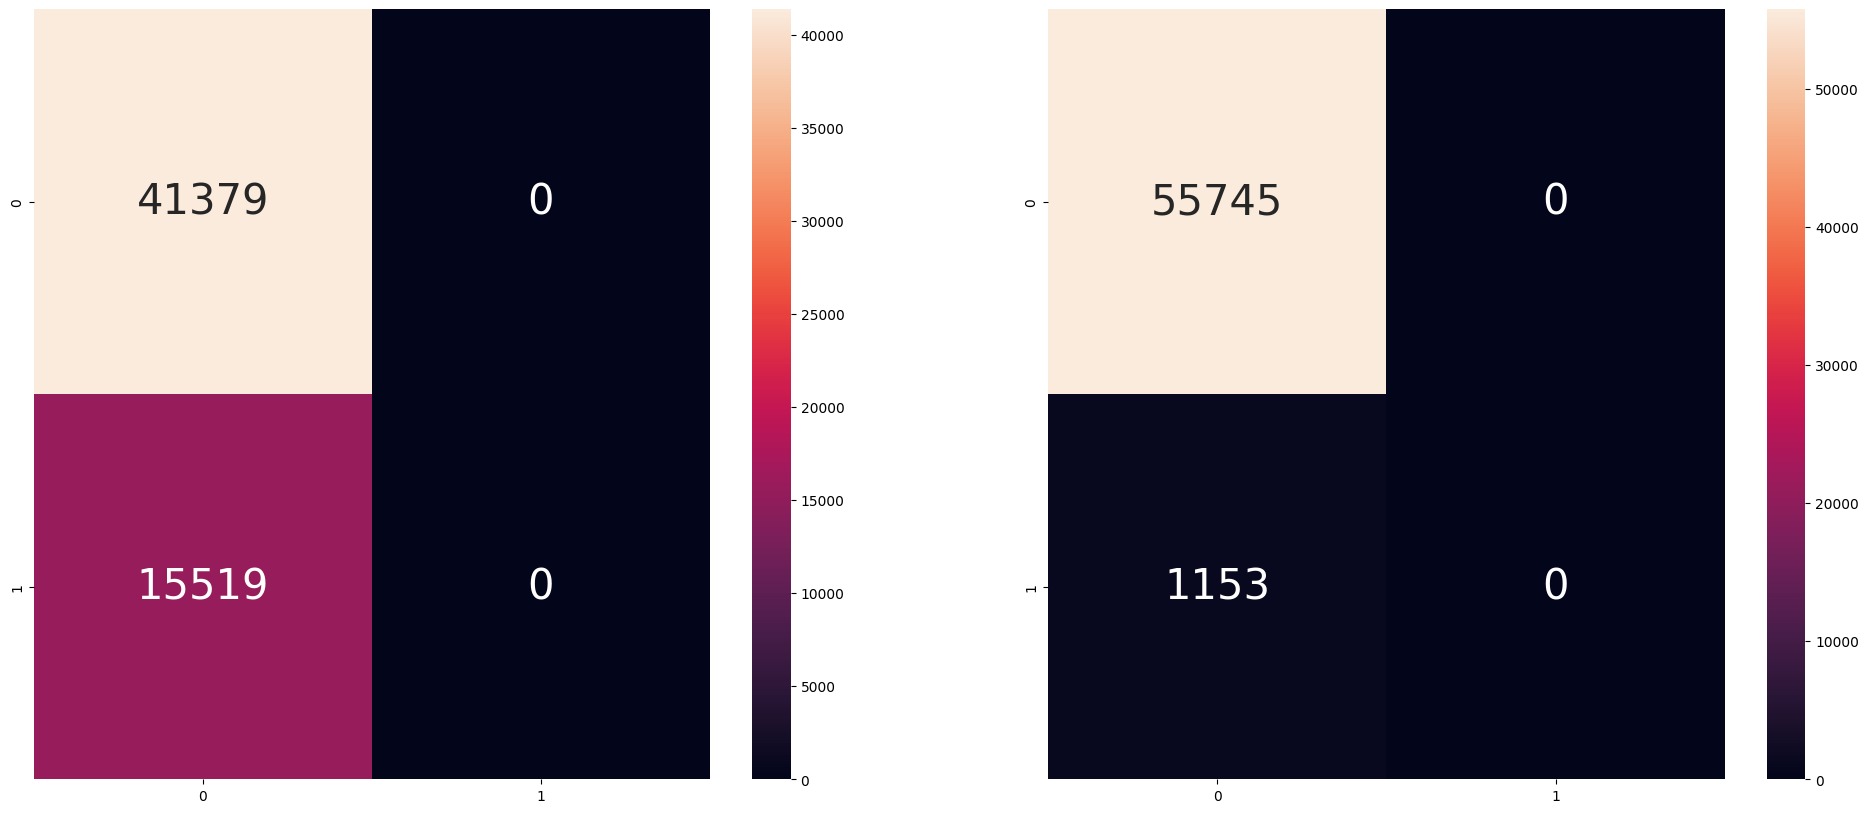

LOGISTIC_REGRESSION
ROC AUC score for premium_user_numerical: 0.5176141166570702
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


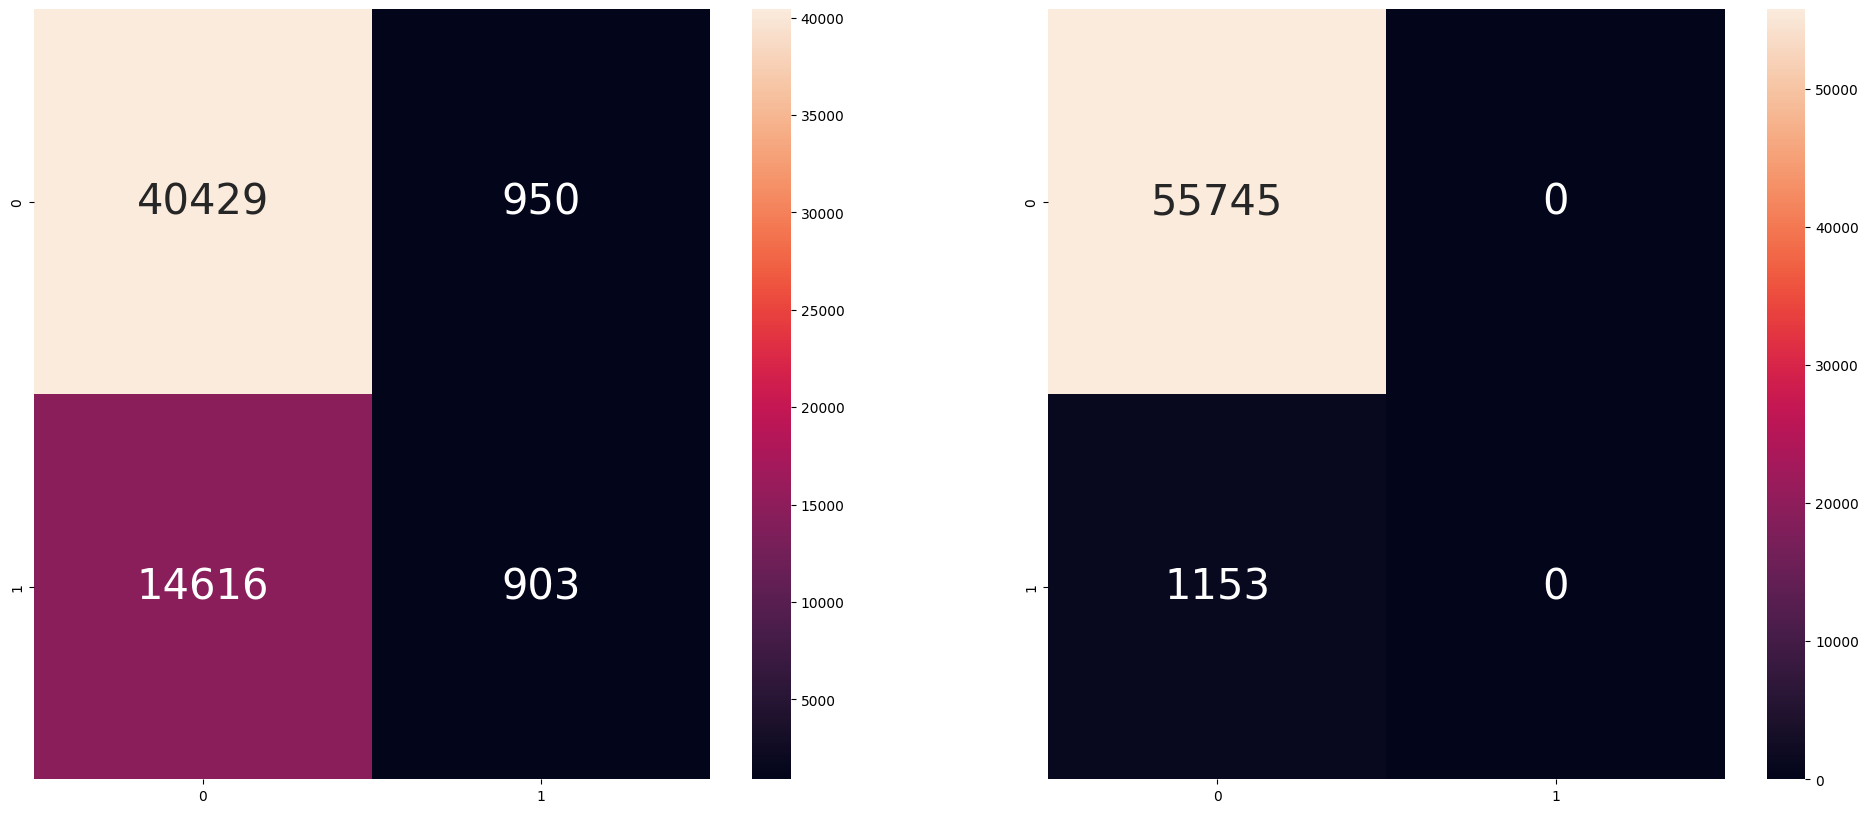

XGB_CLASSIFIER
ROC AUC score for premium_user_numerical: 0.5378211800600361
ROC AUC score for will_buy_premium_next_month_numerical: 0.5040853698428688


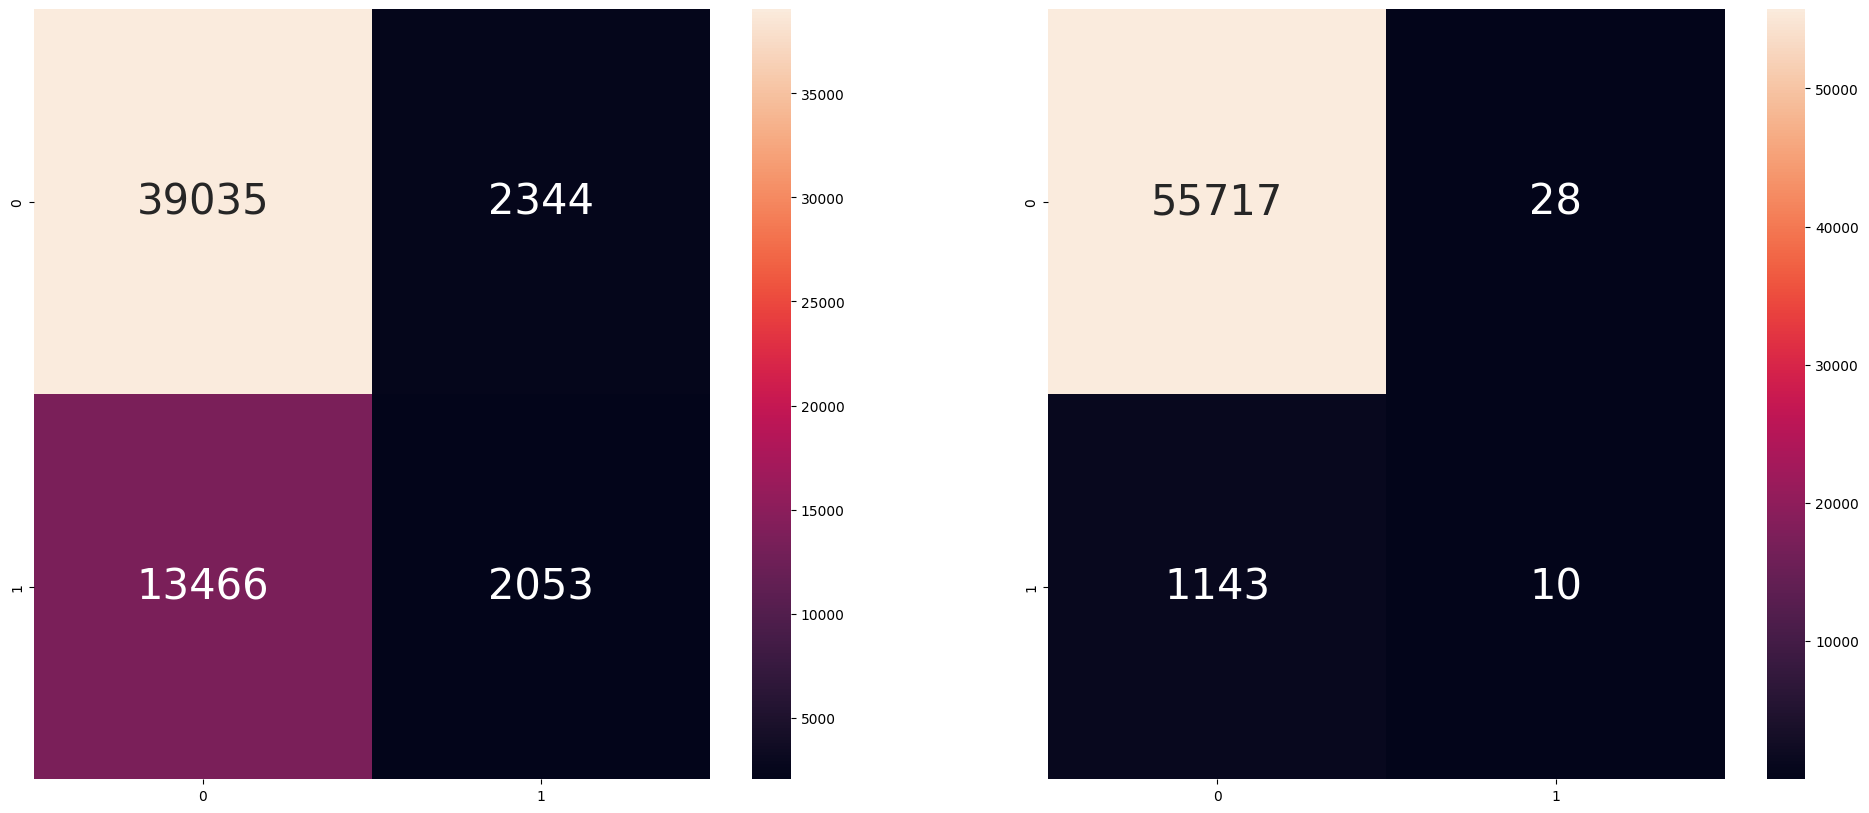

XGB_CLASSIFIER_BEST_ESTIMATOR
ROC AUC score for premium_user_numerical: 0.6794074120708299
ROC AUC score for will_buy_premium_next_month_numerical: 0.7001701077037622


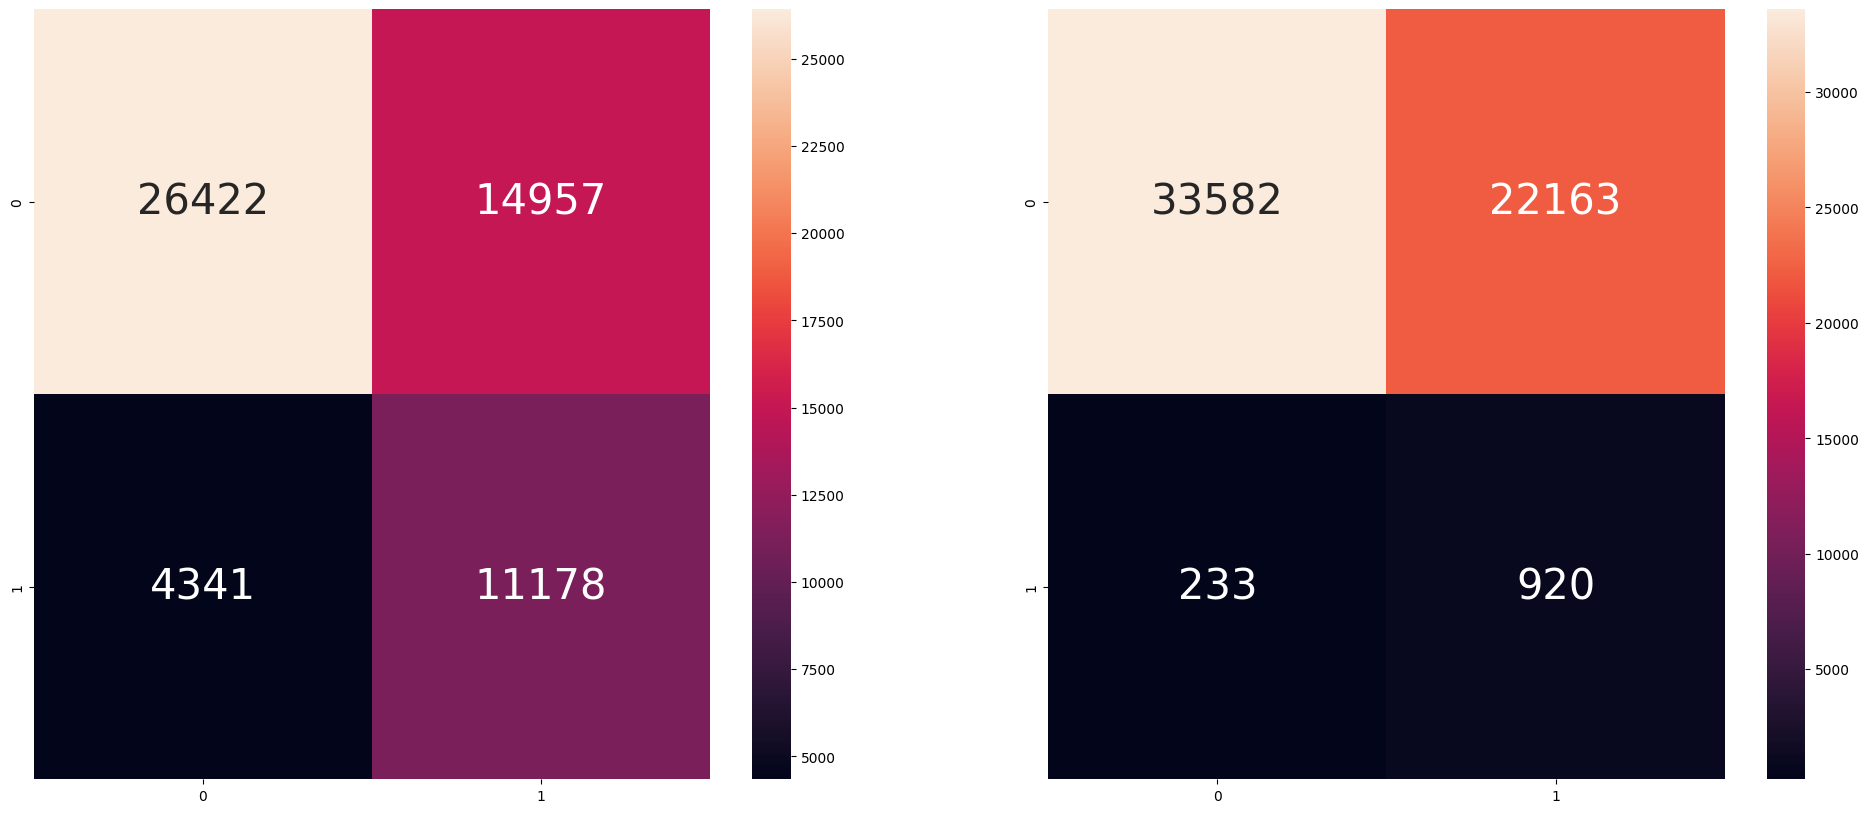

In [13]:
for type in MODEL_TYPES:
    print(type.upper())
    models = MODELS[type]
    plot_confusion_matrix(models, X_test, Y_test)

Analizując wyniki możemy zauważyć, że dla przewidywania `premium_user_numerical` (czy użytkownik kiedykolwiek zakupi premium) najgorzej poradził sobie model naiwny `Dummy`, który każdemu przypisuje klasę większościową. Nieznacznie lepsze wyniki na podobnym poziomie, osiągnęły modele `Logistic Regression` oraz `XGB Classifier`. Najlepsze wyniki osiągnął model `XGB Classifier with Randomized Search`, dzięki optymalizacji hiperparametrów. W przypadku `will_buy_premium_next_month_numerical` (czy użytkownik kupi premium w przeciągu miesiąca) modele `Dummy` oraz `Logistic Regression` w każdym przypadku przewidywały klasę większościową. Model `XGB Classifier` był nieznacznie lepszy. Jedynie model `XGB Classifier with Randomized Search` osiągnął lepszy wynik 0.69, jednak kosztem przypisania większej ilości błędnych predykcji w przypadku klasy większościowej.

### Istotność parametrów

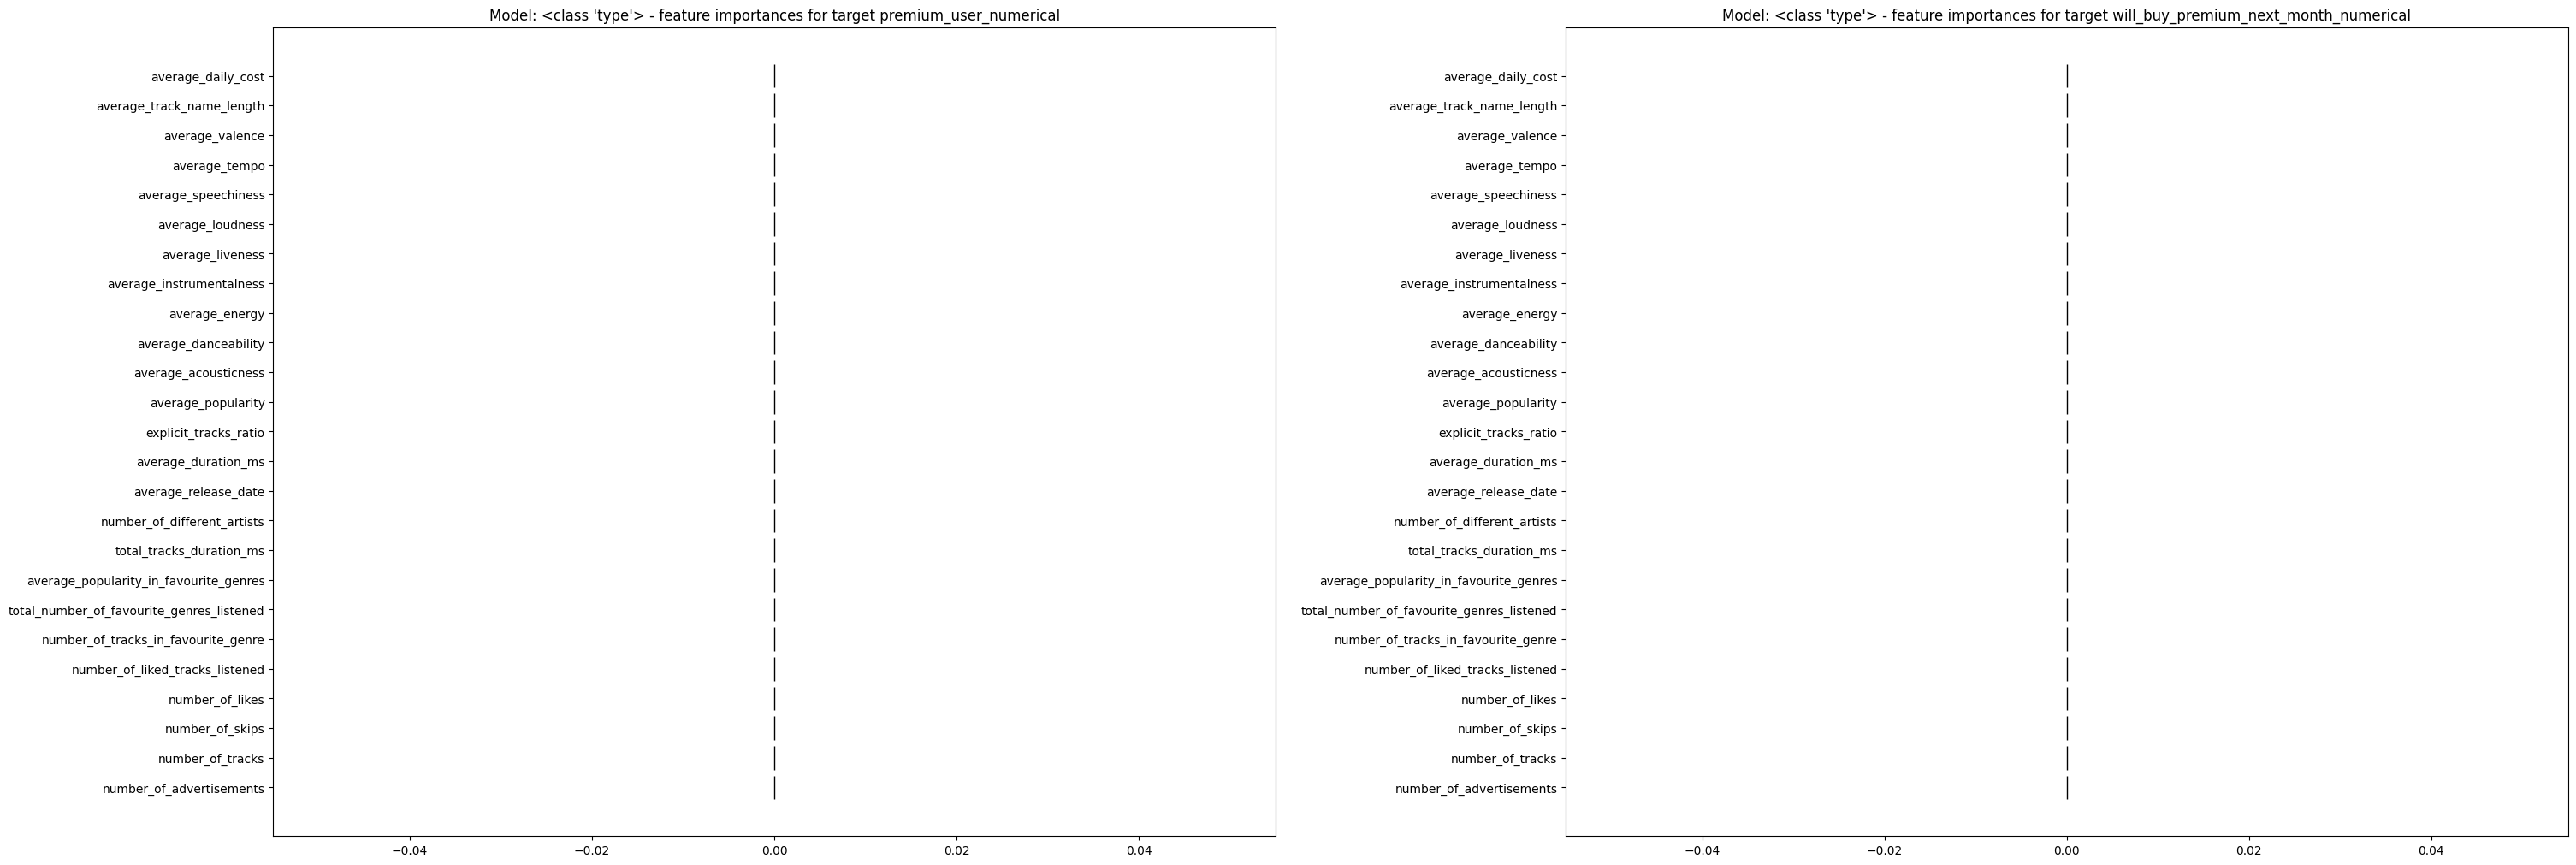

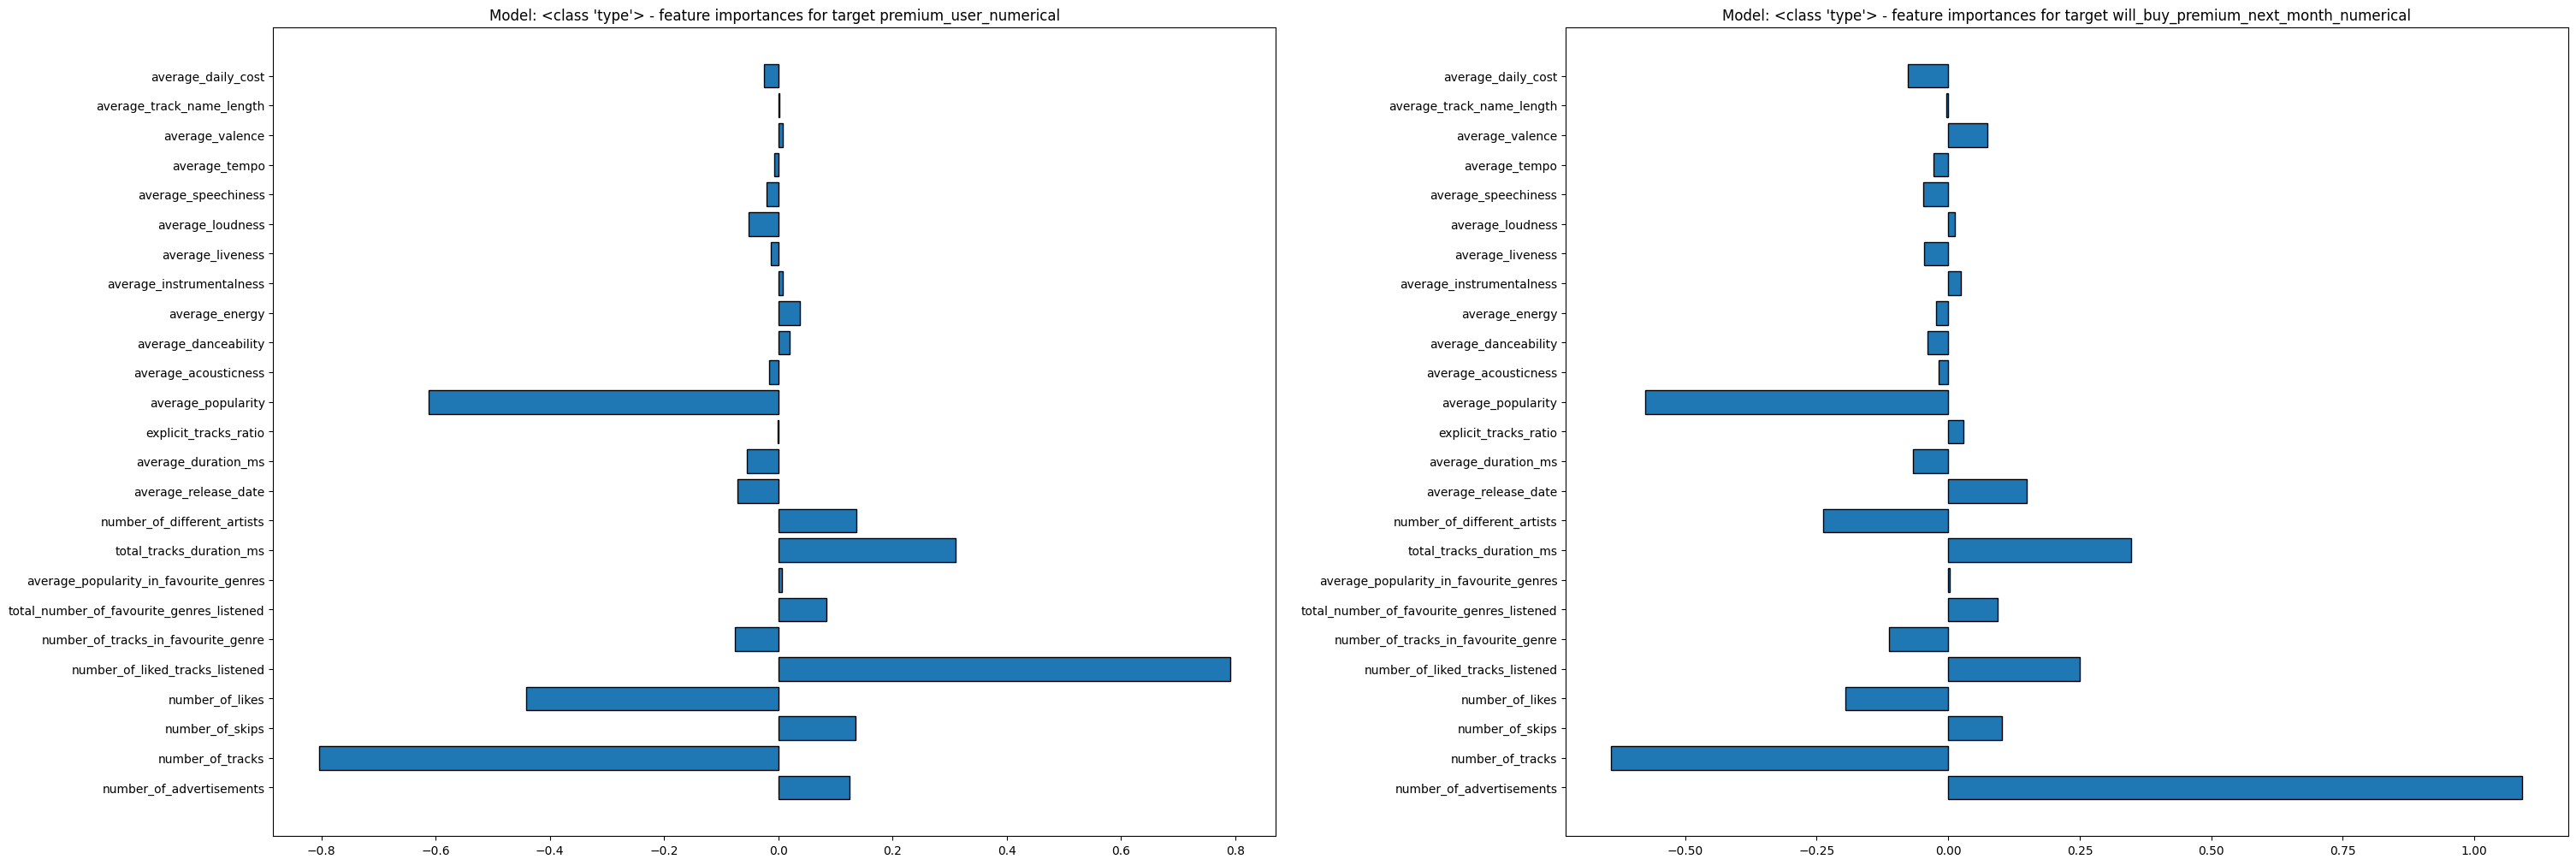

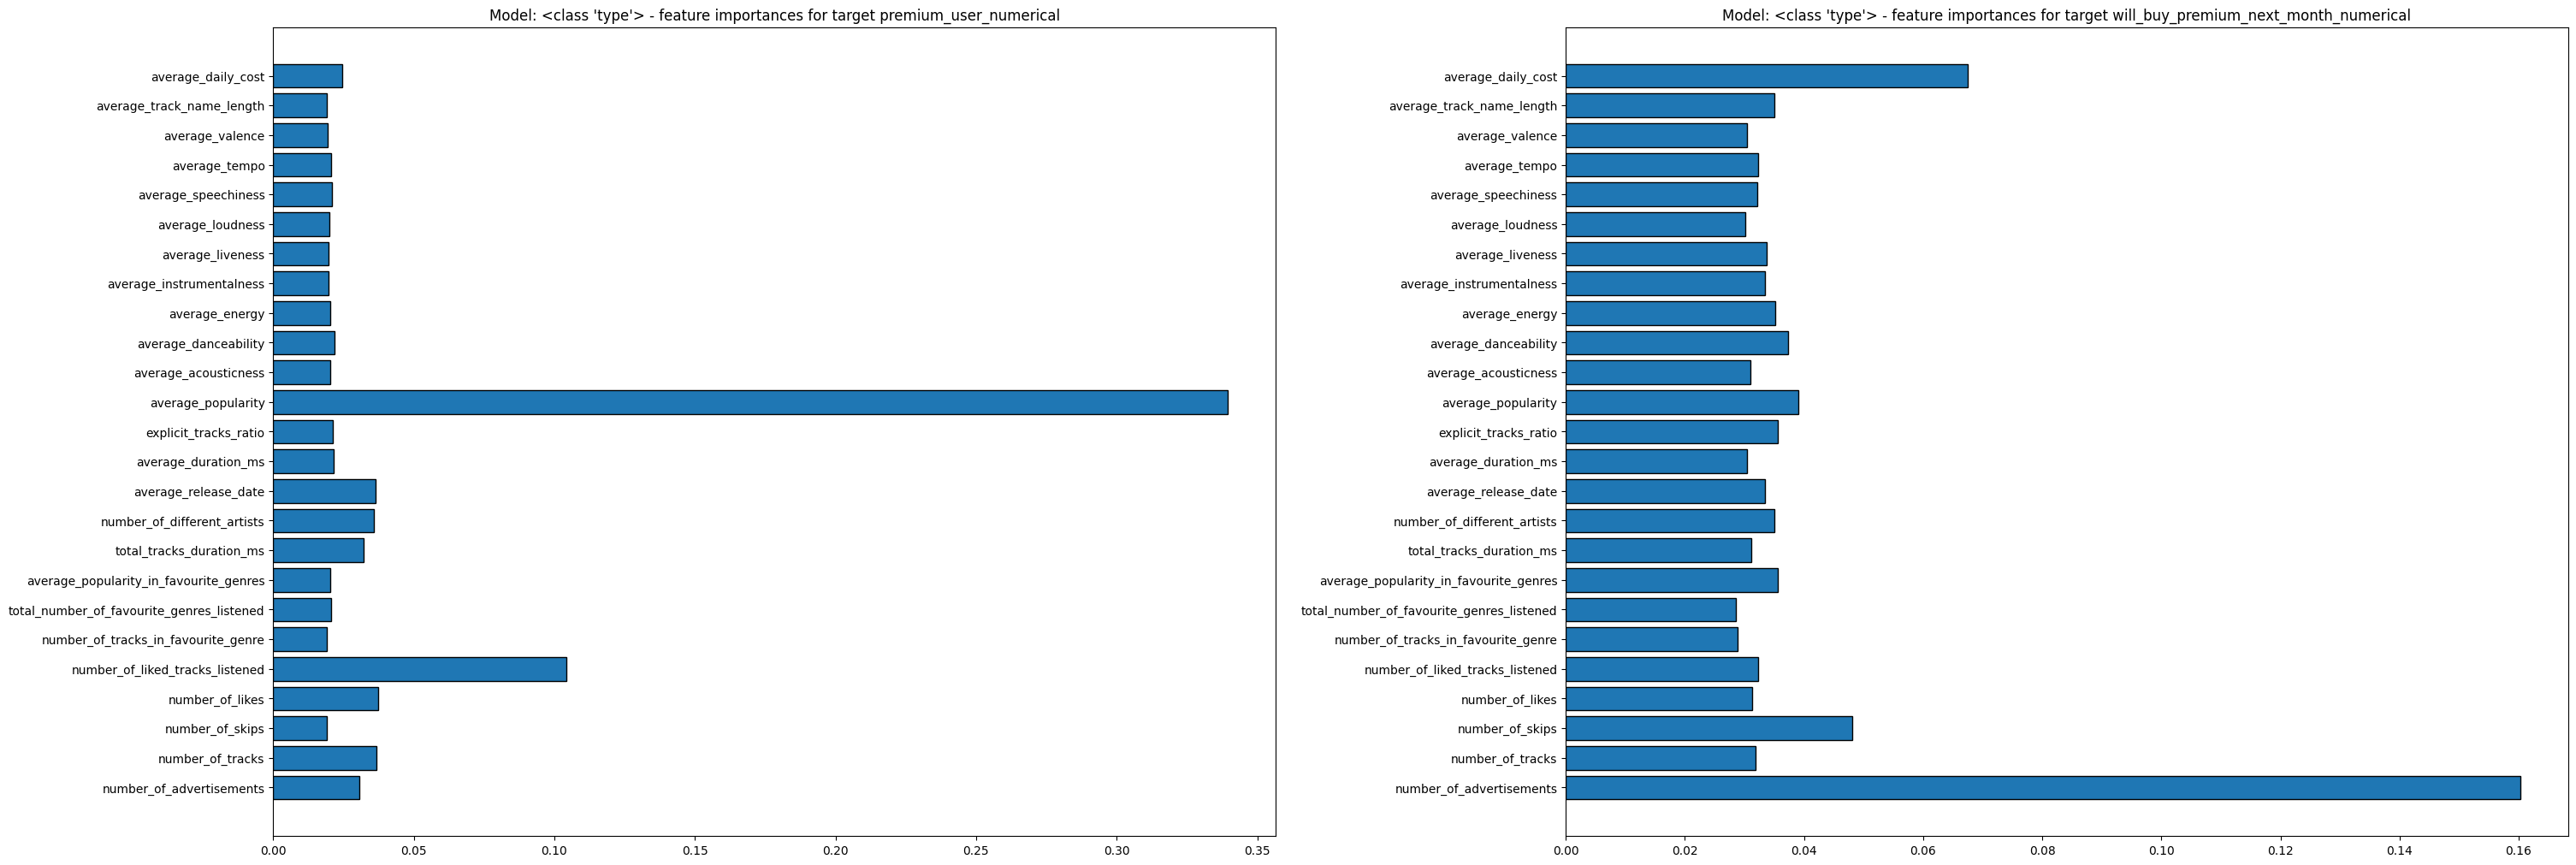

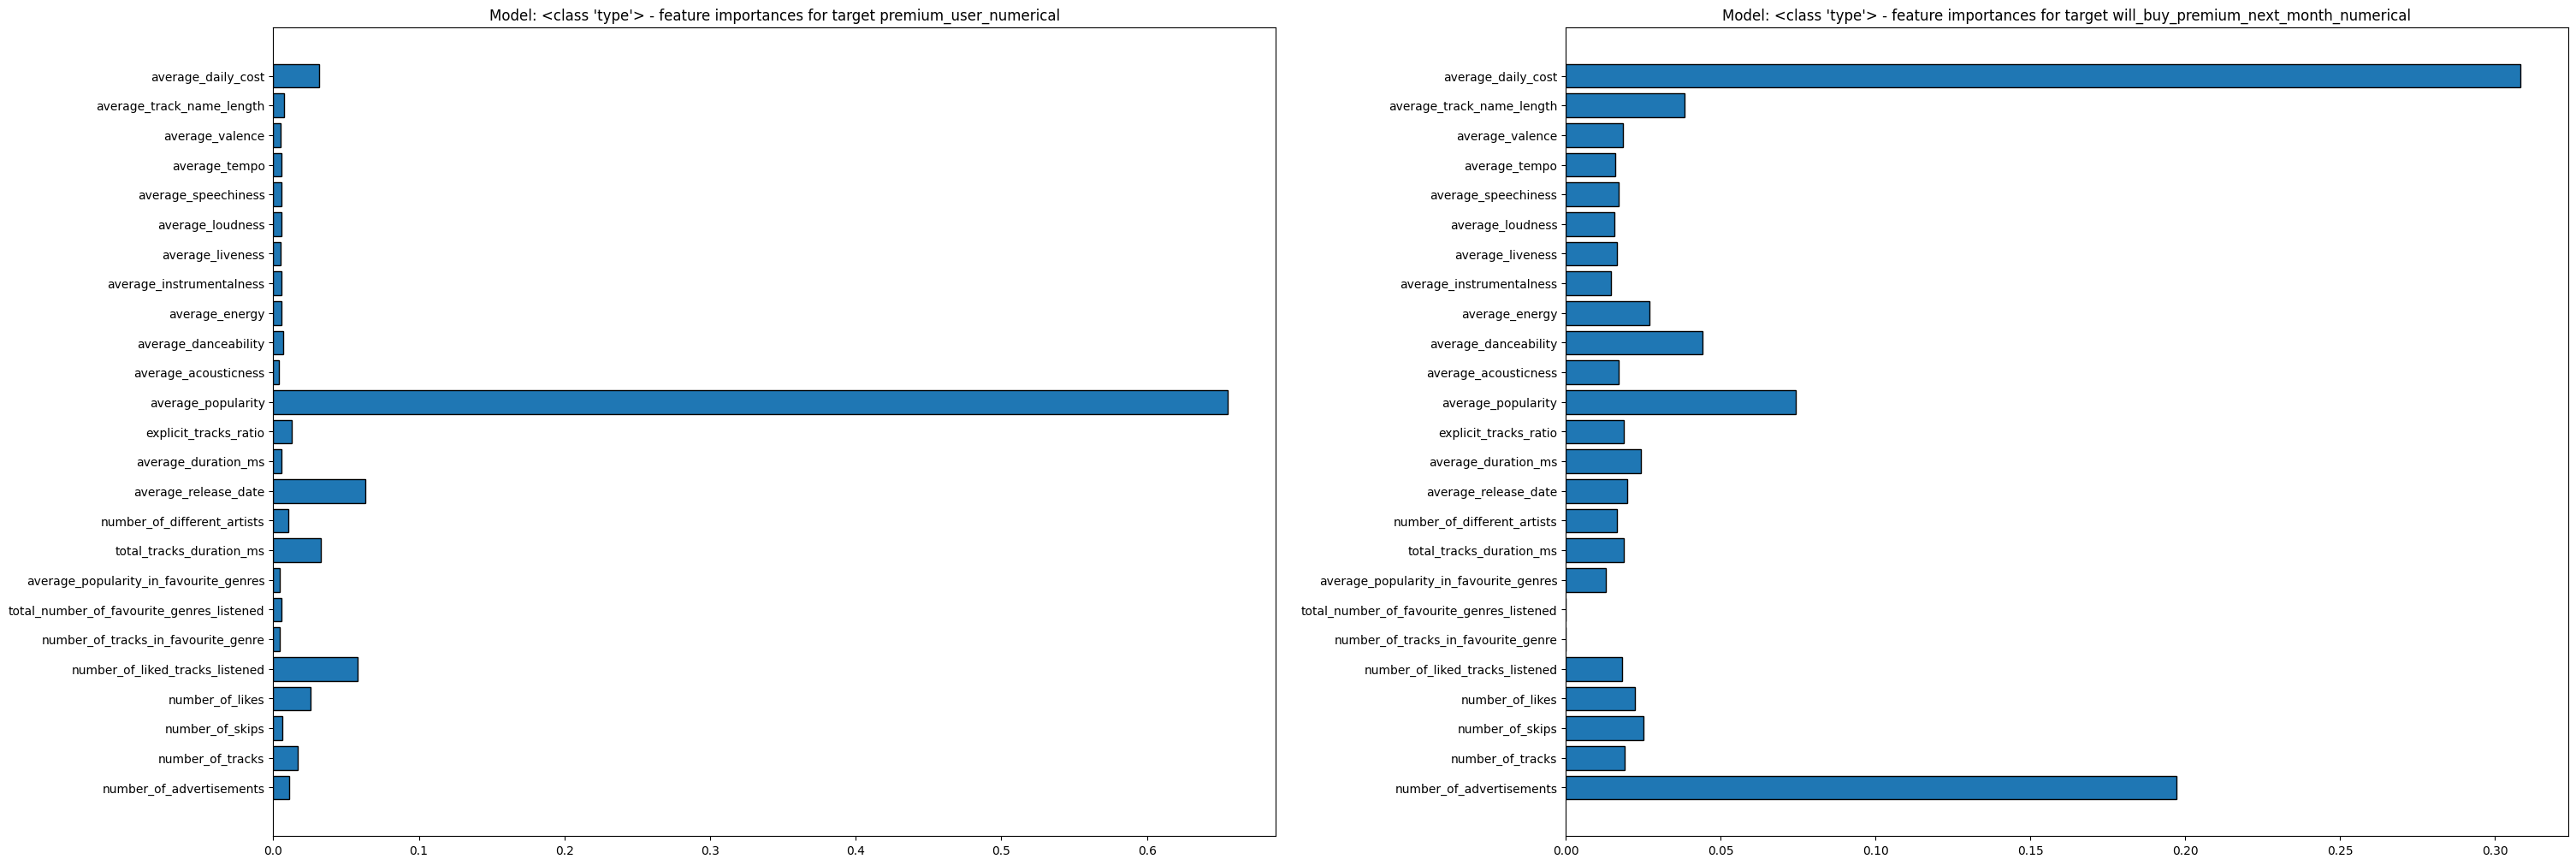

In [14]:
for type in MODEL_TYPES:
    models = MODELS[type]
    plot_feature_importances(models)

Analizując ważność parametrów możemy zauważyć, że większość parametrów jest brana pod uwagę przez modele, jednakże kilka z nich wyróżnia się na tle pozostałych. W przypadku przewidywania dla tego, czy użytkownik zakupi premium w przeciągu miesiąca najważniejszym parametrem jest `number_of_advertisements`, czyli liczba wyświetlanych reklam. Dodatkowo ostatni wytrenowany model uwzględnia jeszcze `average_release_date` oraz `average_daily_cost`. Możemy z tego wnioskować, że aby użytkownik jak najszybciej zakupił premium powinniśmy manipulować ilością wyświetlanych mu reklam. Natomiast w przypadku przewidywania tego, czy użytkownik kiedykolwiek zakupi premium ważniejsze okazuje się `average_popularity` oraz `number_of_licked_tracks_listened` co oznacza, że użytkownicy, którzy słuchają popularniejszych utworów oraz słuchają polubionych utworów są bardziej skłonni do zakupu premium. Może oznaczać, to, że w długofalowej perspektywie ważniejsze może być proponowanie użytkownikowi utworów, które są popularne oraz utworów, które użytkownik polubił, niż wyświetlanie reklam. 

### Eksperymenty A/B
Trenujemy wszystkie modele na danych do 2023, a wyniki dla wszystkich modeli zapisujemy do plików pkl. Uruchamiamy mikroserwis, który wczytuje te modele. Następnie dane użytkowników korzystających w roku 2023 dzielimy na różne rzeczywistości i dla każdej z tych grup wykonujemy predykcję z wykorzystaniem naszego mikroserwisu, a następnie przeprowadzamy porównanie za pomocą testu t-studenta.

In [15]:
X_train = pd.DataFrame(
    pipeline.fit_transform(TRAIN_DATA[FEATURES]),
    columns=FEATURES
)
Y_train = TRAIN_DATA[TARGETS]
for type in MODEL_TYPES:
    estimators = {}
    for target in TARGETS:
        y_train = Y_train[target]
        estimators[target] = MODEL_CONSTRUCTORS[type](
            X_train, y_train, get_params(MODELS[type][target])
        )
    model = IUMModel(pipeline, estimators)
    with open(f'models/{type}.pkl', 'wb') as f:
        pickle.dump(model, f)

In [16]:
URL = 'http://127.0.0.1:5000'

In [17]:
requests.post(f'{URL}/init/')

<Response [200]>

In [18]:
for type in MODEL_TYPES:
    url = f'{URL}/ab/'

    for i in range(0, len(TEST_DATA)):
        row = TEST_DATA.iloc[i].to_dict()
        requests.post(url, json=row)  # type: ignore

In [19]:
result = SERVICE_PREDICTION_MODEL_INIT

for type in MODEL_TYPES:
    result[type] = {}
    for target in TARGETS:

        result[type][target] = pd.merge(
            pd.read_csv(
                f'ab_experiment/{type}-{target}.csv'
            ),
            TEST_DATA,
            on=['user_id', 'year', 'month']
        ).rename(columns={target: 'ground_truth'})[AB_RESULT]

In [20]:
for type in MODEL_TYPES:
    for target in TARGETS:
        result[type][target].to_csv(f'ab_result/{type}-{target}.csv')

In [9]:
result = {}
for type in MODEL_TYPES:
    result[type] = {}
    for target in TARGETS:
        result[type][target] = pd.read_csv(f'ab_result/{type}-{target}.csv')

DUMMY
ROC AUC score for premium_user_numerical: 0.5
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


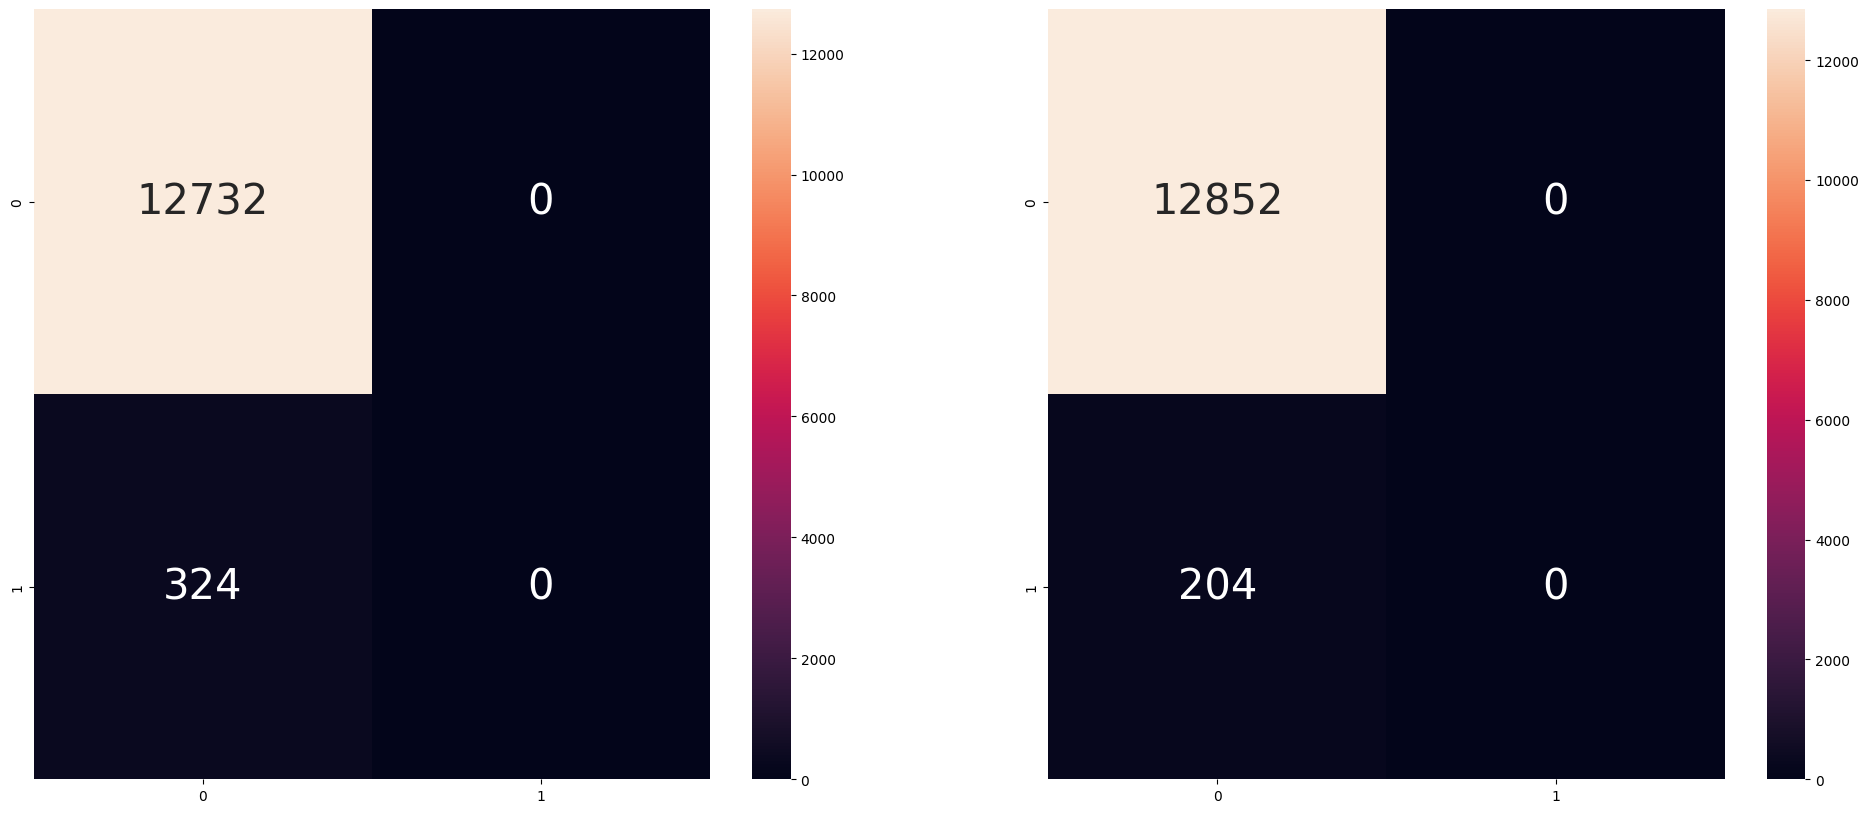

LOGISTIC_REGRESSION
ROC AUC score for premium_user_numerical: 0.5193098568098568
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


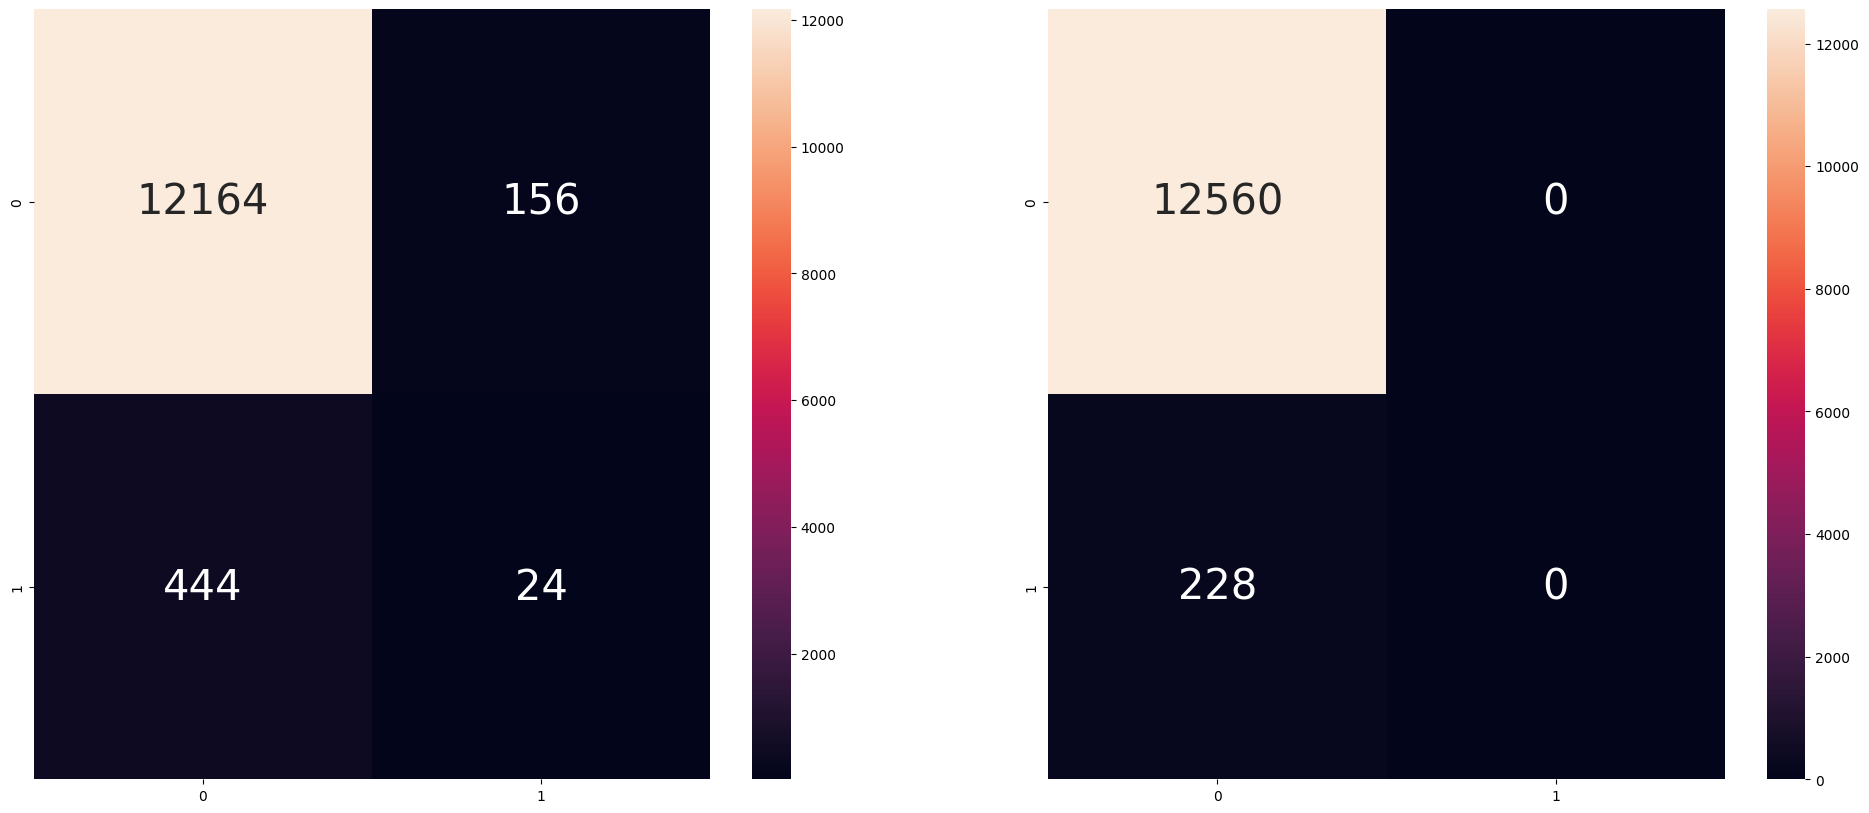

XGB_CLASSIFIER
ROC AUC score for premium_user_numerical: 0.5278439076003764
ROC AUC score for will_buy_premium_next_month_numerical: 0.5121951219512195


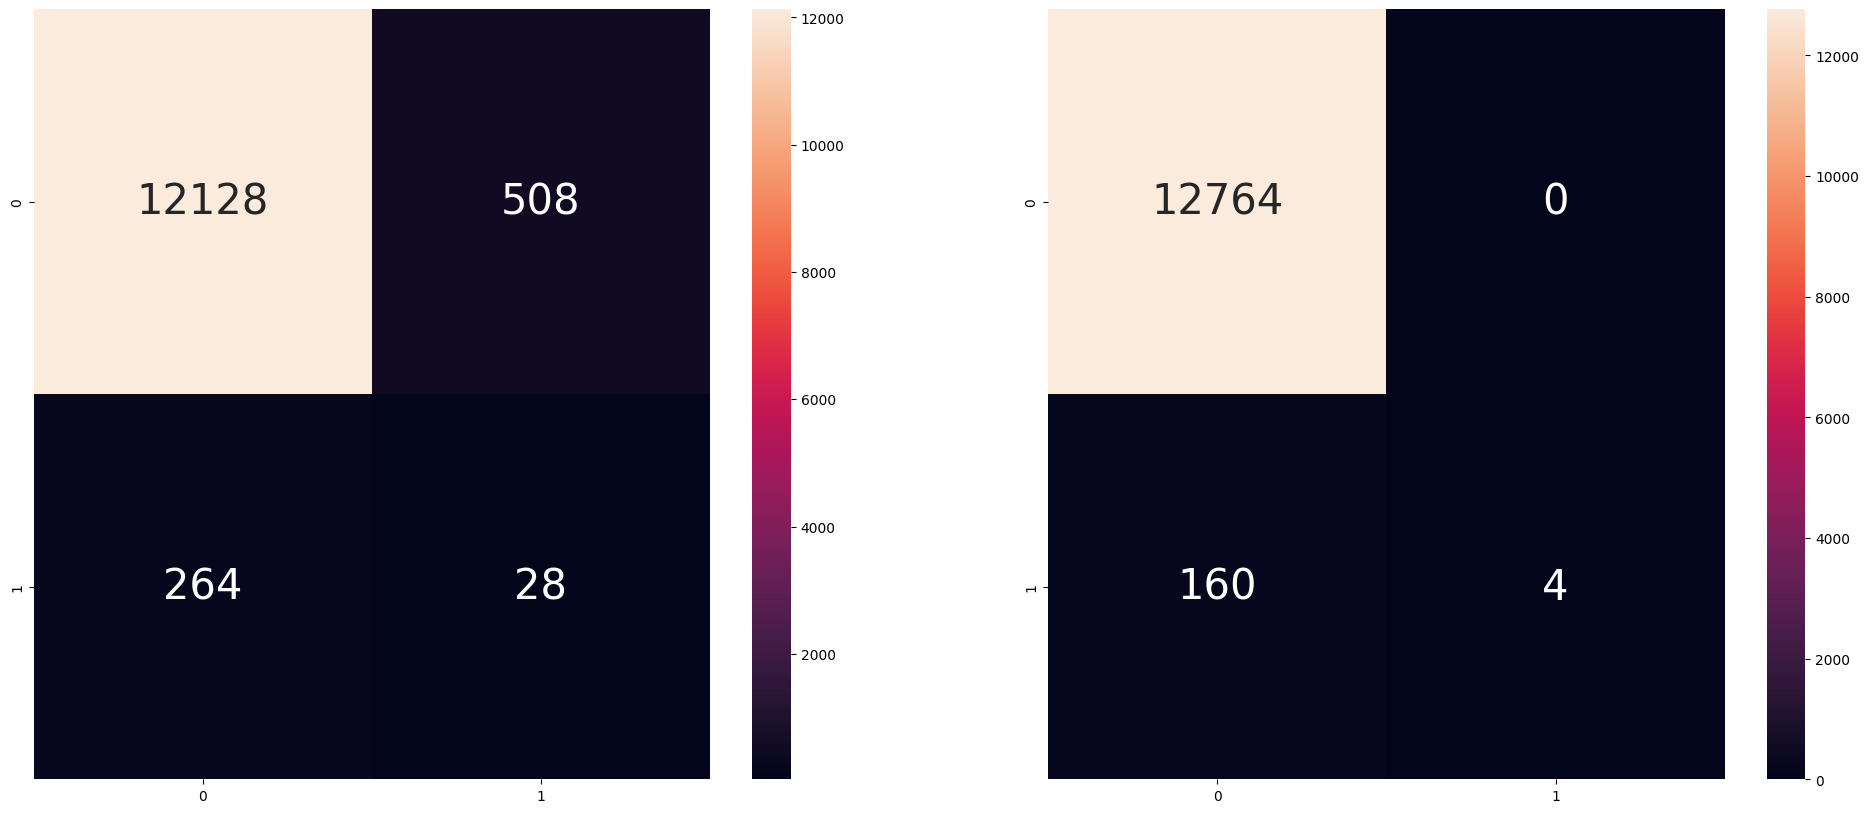

XGB_CLASSIFIER_BEST_ESTIMATOR
ROC AUC score for premium_user_numerical: 0.6737067622312246
ROC AUC score for will_buy_premium_next_month_numerical: 0.6558928019771393


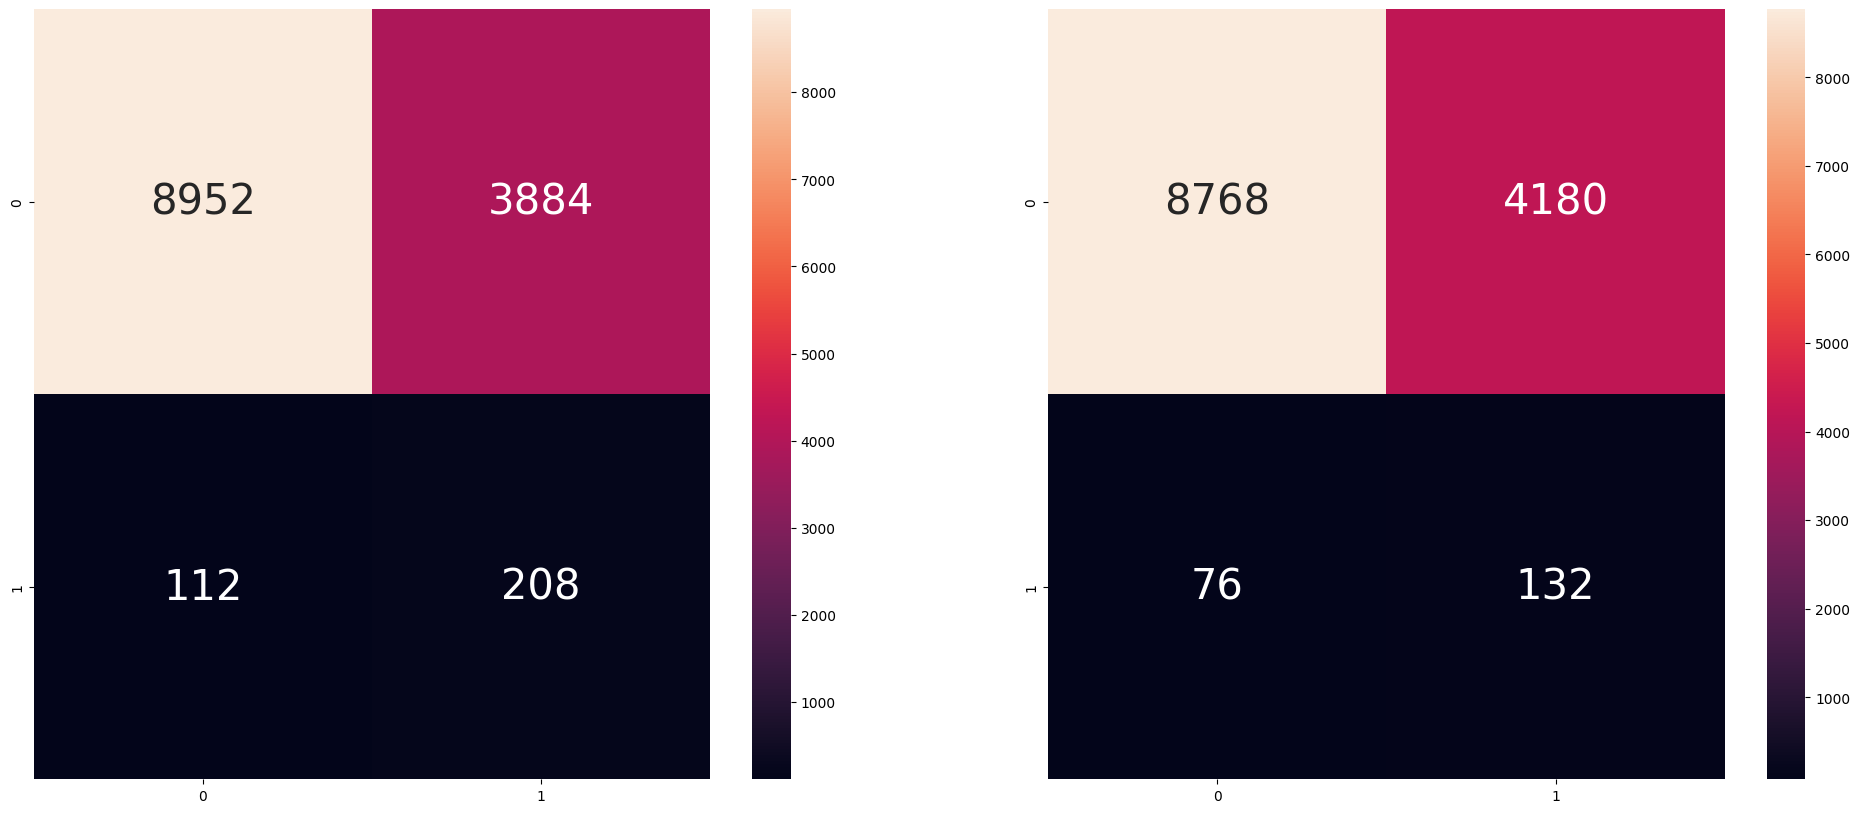

In [10]:
for type in MODEL_TYPES:
    print(type.upper())
    plot_confusion_matrix_ab_experiment(result[type])
    plt.show()

Ustalamy hipotezę zerową $H_0$ mówiącą, że pierwszy model nie jest lepszy od drugiego oraz hipotezę alternatywną $H_1$ głoszącą, że model pierwszy jest lepszy od modelu drugiego.

Na podstawie tabeli rozkładu t-studenta, przyjętego istotności statystycznej jako $0.05$ oraz stopni swobody $12 + 12 - 2 = 22$ ustaliliśmy wartość parametru $t_\alpha$ jako $2.074$

$$
t = \frac{\overline{q}_A - \overline{q}_B}{s_p  \sqrt{\frac{1}{n_A} + \frac{1}{n_B}}}
$$

$$
s_p = \sqrt{\frac{(n_A - 1) \sigma^2 + (n_B - 1) \sigma^2}{n_A + n_B - 2}}
$$

In [15]:
BUCKETS = 7
T_ALPHA = 1.782


def s_p(sigma_A: float, sigma_B: float) -> float:
    return sqrt(
        ((BUCKETS - 1) * (sigma_A ** 2) + (BUCKETS - 1) * (sigma_B ** 2))
        / (BUCKETS + BUCKETS - 2)
    )


def t(q_A: float, q_B: float, s_p_value: float) -> float:
    return (q_A - q_B) / (s_p_value * sqrt(1 / BUCKETS + 1 / BUCKETS))

In [16]:
np.random.seed(RANDOM_SEED)

for type_A, type_B in itertools.product(MODEL_TYPES, MODEL_TYPES):
    if type_A == type_B:
        continue
    print(f'{type_A} vs {type_B}'.upper())
    compare_models(result, type_A, type_B, BUCKETS, T_ALPHA, s_p, t)

DUMMY VS LOGISTIC_REGRESSION
premium_user_numerical
t_value =  -2.784580296751739
We can't say that dummy is better than logistic_regression

will_buy_premium_next_month_numerical
t_value =  0
We can't say that dummy is better than logistic_regression

DUMMY VS XGB_CLASSIFIER
premium_user_numerical
t_value =  -1.3600726535610081
We can't say that dummy is better than xgb_classifier

will_buy_premium_next_month_numerical
t_value =  -0.9999999999999966
We can't say that dummy is better than xgb_classifier

DUMMY VS XGB_CLASSIFIER_BEST_ESTIMATOR
premium_user_numerical
t_value =  -3.514142284571118
We can't say that dummy is better than xgb_classifier_best_estimator

will_buy_premium_next_month_numerical
t_value =  -3.4684898717609145
We can't say that dummy is better than xgb_classifier_best_estimator

LOGISTIC_REGRESSION VS DUMMY
premium_user_numerical
t_value =  2.4759789617904056
logistic_regression is better than dummy

will_buy_premium_next_month_numerical
t_value =  0
We can't say t

Z przeprowadzonego eksperymentu wynika, że model `XGB Classifier with Randomized Search` jest lepszy od reszty modeli w przewidywaniu wartości `will_buy_premium_next_month_numerical` oraz jest lepszy od modelu naiwnego `Dummy` w przypadku przewidywania wartości `premium_user_numerical`.

## Analiza kryterium sukcesu

W pierwszym etapie przyjęte kryterium sukcesu oparte na metryce accuracy okazało się niewłaściwe, ponieważ miało miejsce silne niezbalansowanie danych, a metryka accuracy nie skupiała się na przewidywaniu osób, które kupią subskrypcję premium, lecz raczej na poprawności ogólnej predykcji. Model dummy, który przypisywał większościową grupę, osiągał zatem wysoką dokładność w tym kontekście.

Naszym nowym kryterium sukcesu jest metryka ROC AUC (Receiver Operating Characteristic Area Under Curve), która skupia się na zdolności modelu do rozróżniania pomiędzy klasami, a w tym przypadku na zdolności do przewidywania użytkowników, którzy zakupią subskrypcję premium. Metryka ta preferuje identyfikację użytkowników premium, a nie dostosowuje się jedynie do grupy większościowej. Dla nas istotniejsza jest informacja, czy ktoś kupi subskrypcję, a nie tylko informacja, że nikt nie kupił.

W związku z tym, ustaliliśmy nową wartość progową dla oceny sukcesu, która wynosi #TODO. Oznacza to, że projekt zostaje uznany za zaliczony, jeśli osiągnie wynik powyżej tego progu. Ta wartość progowa jest odpowiednia dla metryki ROC AUC i bardziej adekwatna do naszych potrzeb, uwzględniając istotność predykcji zakupu subskrypcji premium.

Wprowadzenie nowego kryterium sukcesu pozwoliło nam lepiej ocenić projekt i skupić się na rzeczywistej wartości predykcji w kontekście naszych celów.